In [4]:
import pickle
import numpy as np
from itertools import product
from bitstring import BitArray, Bits, BitStream
from sklearn.datasets import load_sample_image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

The objective of this notebook is to compress images using kmeans clustering.

# Image Format

Stores a RGB image using less bytes, mapping each pixel to a ID and saving a dictionary of ID to a RGB value.

In [5]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))

        self._mat2bytes(mat_rgb_ids)

    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()

        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=int(rgb_id), length=self.num_bits_uint_))

    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_

        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)

        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]

        return im_rgb

# Uniform quantization

Divide the RBG values in n parts uniformally, categorizes all pixel in the image in one of these parts and returns the image as ID matrix and a ID to RBG dictionary.

In [6]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch) * bin_size) + bin_size//2)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8(((im_qt_rgb) * bin_size) + bin_size//2)

    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}

    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]

    return mat_ids, dict_id2pixel

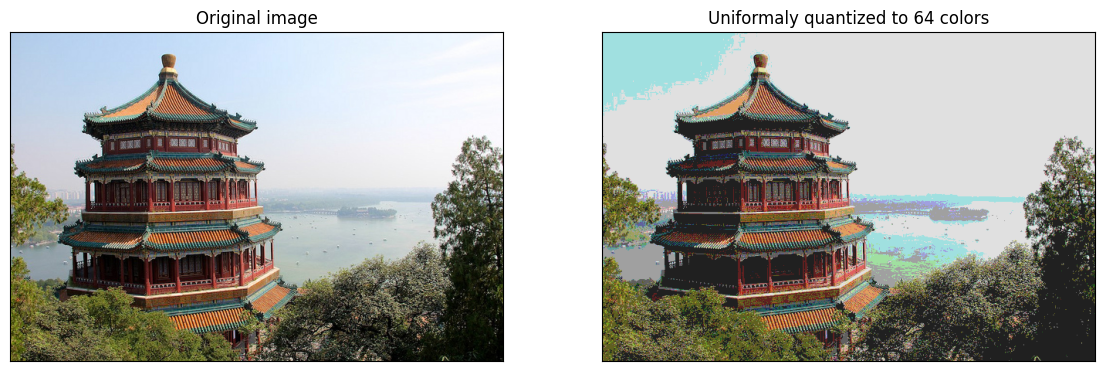

In [7]:
img_china = load_sample_image('china.jpg')

id, dic = uniform_quant(img_china, 64)
img_uniform = MyImgFormat(id, dic)

figure, axis = plt.subplots(1, 2)

axis[0].set_title('Original image')
axis[0].imshow(img_china)
axis[0].get_xaxis().set_visible(False)
axis[0].get_yaxis().set_visible(False)

axis[1].set_title('Uniformaly quantized to 64 colors')
axis[1].imshow(img_uniform.unpack())
axis[1].get_xaxis().set_visible(False)
axis[1].get_yaxis().set_visible(False)

figure.set_size_inches(14, 7)
plt.show()

# K-means quantization

Divide the RBG values in n parts using k-means clusterization, categorizes all pixel in the image in one of these clusters and returns the image as ID matrix and a ID to RBG dictionary.

In [8]:
def kmeans_quant(img, n_colors):

  X = img.reshape((-1, 3))

  kmeans = KMeans(
      n_clusters=n_colors,
      max_iter=10,
      random_state=42,
      n_init=10
  )

  kmeans.fit(X)
  clusters = kmeans.predict(X)
  mat_ids = clusters.reshape(img.shape[:2])
  dict_id2pixel = {i: list(np.uint8(kmeans.cluster_centers_[i])) for i in range(n_colors)}

  return mat_ids, dict_id2pixel

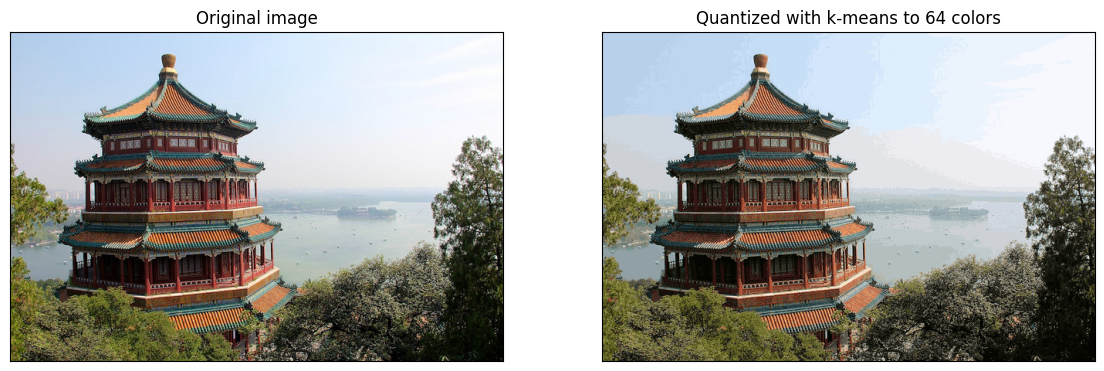

In [9]:
img_china = load_sample_image('china.jpg')

id, dic = kmeans_quant(img_china, 64)
img_kmeans = MyImgFormat(id, dic)

figure, axis = plt.subplots(1, 2)

axis[0].set_title('Original image')
axis[0].imshow(img_china)
axis[0].get_xaxis().set_visible(False)
axis[0].get_yaxis().set_visible(False)

axis[1].set_title('Quantized with k-means to 64 colors')
axis[1].imshow(img_kmeans.unpack())
axis[1].get_xaxis().set_visible(False)
axis[1].get_yaxis().set_visible(False)

figure.set_size_inches(14, 7)
plt.show()

# Comparison

In [10]:
def get_uniform_images(original_image, k_list):
  uniform_images = []

  for k in k_list:
    id, dic = uniform_quant(original_image, k)
    uniform_images.append(MyImgFormat(id, dic).unpack())

  return uniform_images

In [11]:
def get_kmeans_images(original_image, k_list):
  kmeans_images = []

  for k in k_list:
    id, dic = kmeans_quant(original_image, k)
    kmeans_images.append(MyImgFormat(id, dic).unpack())

  return kmeans_images

In [12]:
def MSE(original_image, quant_img):
  mse = 0
  for i in range(original_image.shape[0]):
    for j in range(original_image.shape[1]):
      for k in range(3):
        mse += (int(original_image[i,j,k]) - int(quant_img[i,j,k]))**2
  mse = mse/(original_image.shape[0]*original_image.shape[1]*3)
  return mse

def get_MSEs(original_image, uniform_images, kmeans_images):
  uniform_MSEs = []
  kmeans_MSEs = []

  for image in uniform_images:
    uniform_MSEs.append(MSE(original_image, image))

  for image in kmeans_images:
    kmeans_MSEs.append(MSE(original_image, image))

  return uniform_MSEs, kmeans_MSEs

In [13]:
def plot(uniform_images, kmeans_images, uniform_MSEs, kmeans_MSEs, k_list):

  figure, axis = plt.subplots(len(k_list)+1, 2)

  for i in range(len(k_list)):
    axis[i][0].set_title(f'Uniformally quantized to {k_list[i]} colors')
    axis[i][0].imshow(uniform_images[i])
    axis[i][0].get_xaxis().set_visible(False)
    axis[i][0].get_yaxis().set_visible(False)

    axis[i][1].set_title(f'Quantized with k-means to {k_list[i]} colors')
    axis[i][1].imshow(kmeans_images[i])
    axis[i][1].get_xaxis().set_visible(False)
    axis[i][1].get_yaxis().set_visible(False)

  axis[len(k_list)][0].set_title(f'MSE in uniformally quantized images')
  axis[len(k_list)][0].plot(k_list, uniform_MSEs, 'bx-')
  axis[len(k_list)][0].set_xlabel('colors')
  axis[len(k_list)][0].set_ylabel('MSE')

  axis[len(k_list)][1].set_title(f'MSE in images quantized with kmeans')
  axis[len(k_list)][1].plot(k_list, kmeans_MSEs, 'bx-')
  axis[len(k_list)][1].set_xlabel('colors')
  axis[len(k_list)][1].set_ylabel('MSE')

  figure.set_size_inches(12, 5*(len(k_list)+1))
  plt.show()

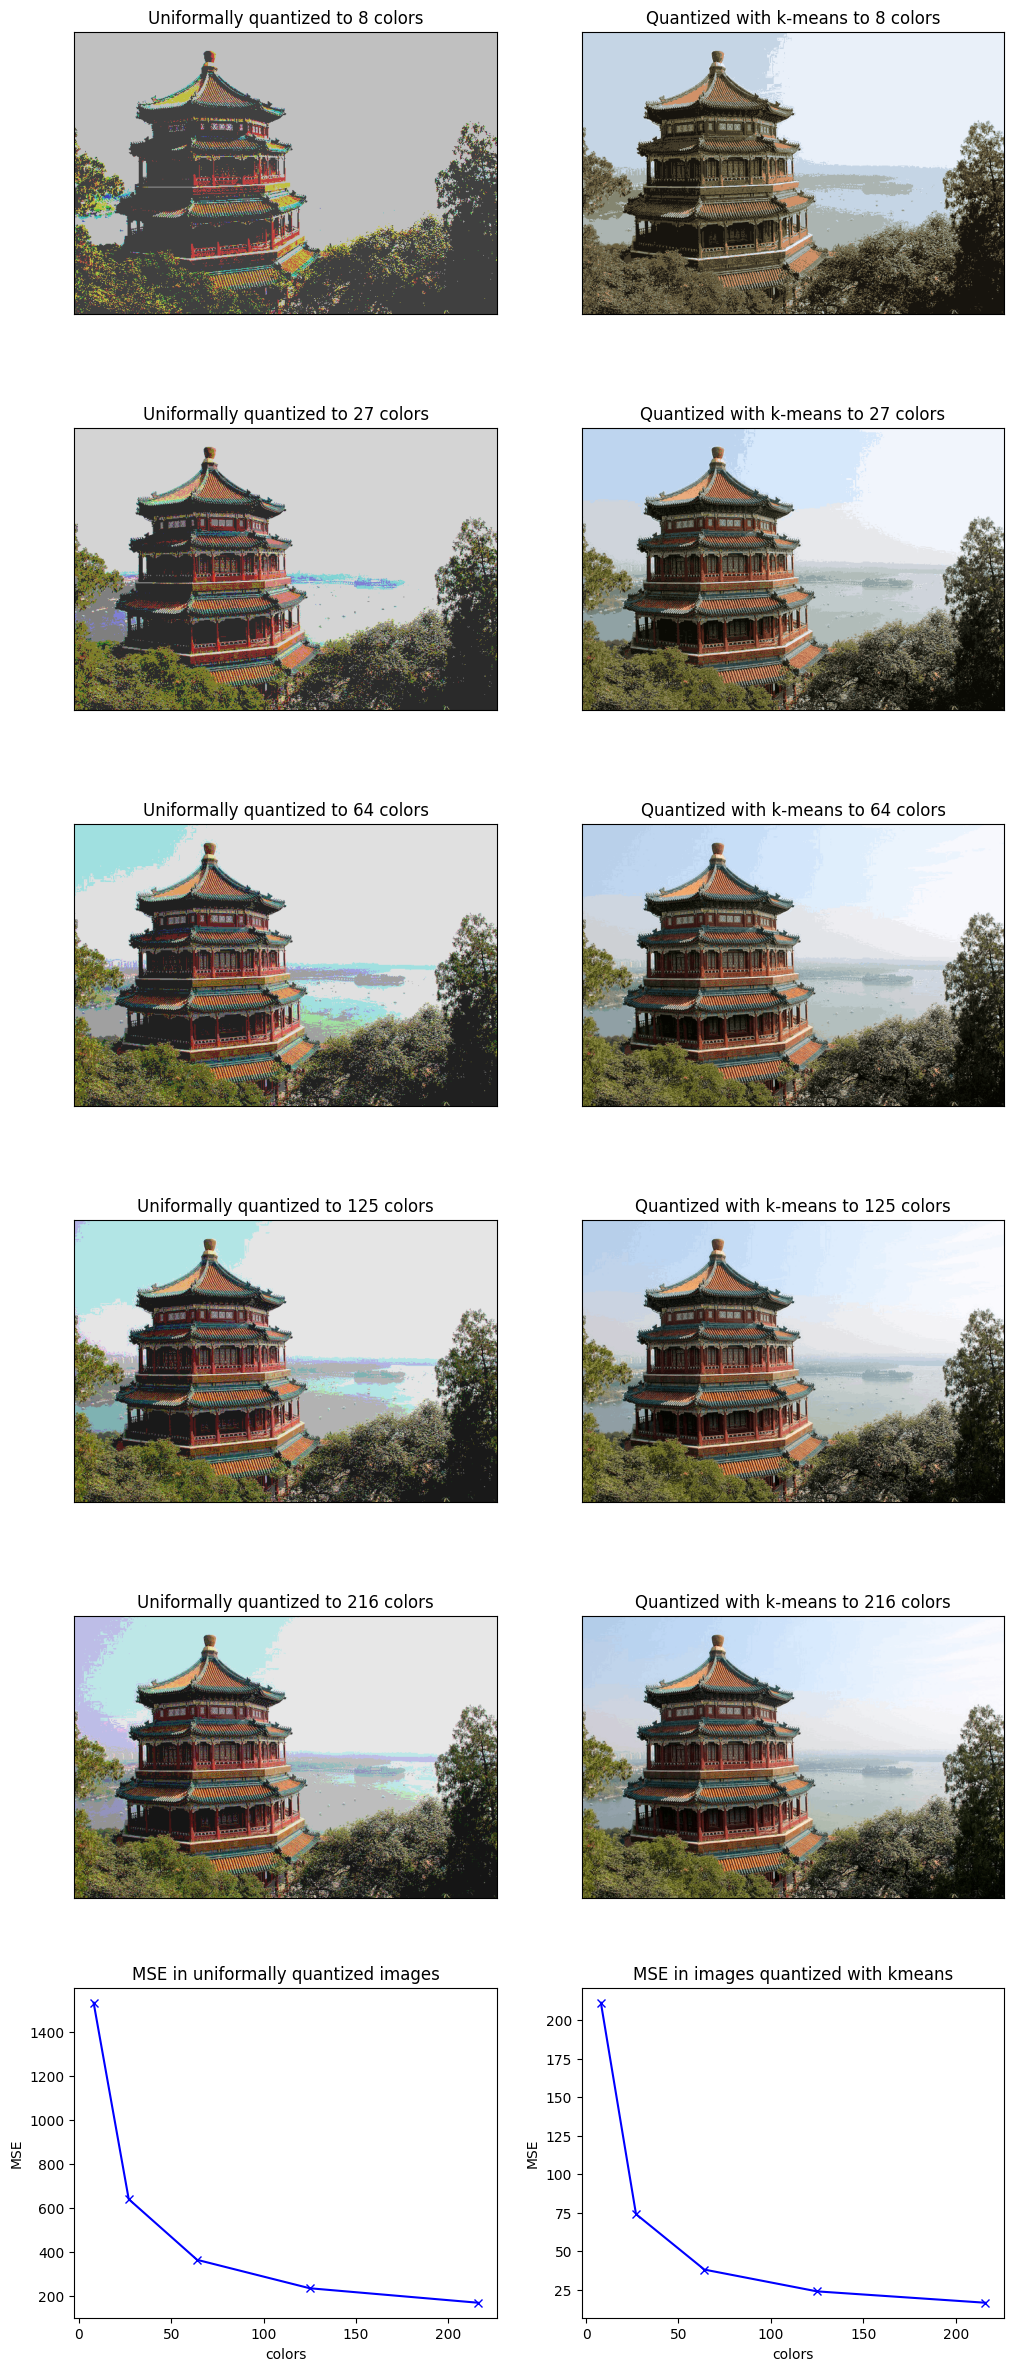

In [15]:
k_list = [8, 27, 64, 125, 216]
uniform_images = get_uniform_images(img_china, k_list)
kmeans_images = get_kmeans_images(img_china, k_list)
uniform_MSEs, kmeans_MSEs = get_MSEs(img_china, uniform_images, kmeans_images)
plot(uniform_images, kmeans_images, uniform_MSEs, kmeans_MSEs, k_list)